### PS4
### Hyunwoo Roh
### MACS 30150

# Q1 
### (a) plot a histogram of percentages of the income txt data with 30 bins. 
Make sure that the bins are weighted using the normed=True option. Make sure your plot has correct x-asxis and y-axis labels as well as a plot title. 

In [46]:
import numpy as np
import scipy.stats as sts
import math
import matplotlib.pyplot as plt
%matplotlib notebook
income= pd.loadtxt('incomes.txt', delimiter=',', unpack=True)

<IPython.core.display.Javascript object>


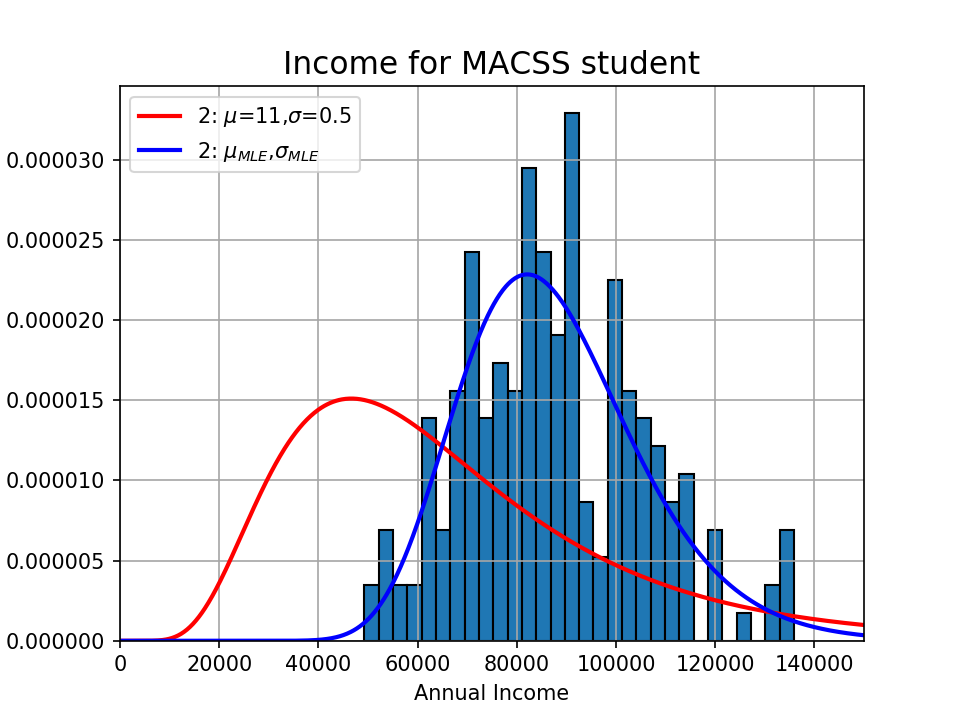

C:\Users\ericr\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


(0, 150000)

In [21]:
plt.hist(income, 30, edgecolor='black',normed=True)
plt.title('Income for MACSS student', fontsize=15)
plt.xlabel('Annual Income')
plt.ylabel('Percentages')
plt.xlim([0,150000])

### (b) Plot the log normal PDF with mu = 11 and sigma = 0.5 for 0 <= x <= 150,000. What is the value of the log likelihood value for this parametrization of the distribution and given this data?

In [22]:
# define a function that generates values of a log normal

def lnpdf(sigma, mu, xvec, cutoff):
    '''
    Inputs:
    sigma = scalar > 0, standard deviation of the normally distributed random variable
    mu = scalar, mean of the normally distributed random variable
    xvals = (N, ) vector, values of the normally distributed random variable.
    '''
    if cutoff == 'None':
        prob_notcut = 1.0 - sts.norm.cdf(0, loc=mu, scale=sigma)
    else:
        prob_notcut = (sts.norm.cdf(cutoff, loc=mu, scale=sigma) -
                       sts.norm.cdf(0, loc=mu, scale=sigma))
            
    pdf_vals    = (1/(xvec*sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (np.log(xvec) - mu)**2 / (2 * sigma**2))  /prob_notcut)

    return pdf_vals

dist_pts = np.linspace(0.001, 150000, 1000)
mu_1 = 11.0
sig_1 = 0.5
pdf_vals = lnpdf(0.5,11.0,dist_pts,150000) #, plot=False

plt.plot(dist_pts, pdf_vals,linewidth=2, color='R', label='2: $\mu$=11,$\sigma$=0.5')
plt.grid(b=True, which='major', color='0.65', linestyle='-')
plt.legend(loc='upper left')

### (b) What is the value of the log likelihood value for this parametrization of the distribution and given this data?

In [23]:
def log_lik_truncnorm(xvals, mu, sigma, cutoff):
    pdf_vals = lnpdf(sigma, mu, xvals, cutoff)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

log_lik_truncnorm(income,mu_1,sig_1,150000)

-2385.856997808558

### (c) Estimate the parameters of the lognormal by maximum likelihood and plot its PDF aginast the PDF from the (b) and the histogram from part (a)

#### Report the ML estimates for mu and sigma

In [24]:
def crit(params, *args):
    mu, sigma = params
    xvals, cutoff = args
    log_lik_val = log_lik_truncnorm(xvals, mu, sigma, cutoff)
    neg_log_lik_val = -log_lik_val
    return neg_log_lik_val

import scipy.optimize as opt
mu_init = mu_1
sig_init = sig_1
params_init = np.array([mu_init, sig_init])
mle_args = (income, 150000)
results = opt.minimize(crit, params_init, args=(mle_args), 
                       bounds=((0.1, None), (0.1, None)))
mu_MLE, sig_MLE = results.x
print('MLE estimates for mu =', mu_MLE, ' MLE estimates for sigma =', sig_MLE)

MLE estimates for mu = 11.359024433194547  MLE estimates for sigma = 0.20817854632246047


#### Report the value of the likelihood function

In [25]:
plt.plot(dist_pts, lnpdf(sig_MLE,mu_MLE,dist_pts,150000),linewidth=2, color='b', label='2: $\mu_{MLE}$,$\sigma_{MLE}$')
plt.grid(b=True, which='major', color='0.65', linestyle='-')
# plt.title(f'Plot of Log Normal PDF with sigma={sig_1} and mean={mu_1}')
# plt.ylabel(r' (\$000s)')
plt.legend(loc='upper left')
print (f"value of the likelihood function: {log_lik_truncnorm(income,mu_MLE,sig_MLE,150000)}")

value of the likelihood function: -2241.7193013689384


In [26]:
OffDiagNeg = np.array([[1, -1], [-1, 1]])
vcv_mle = results.hess_inv.todense() * OffDiagNeg
stderr_mu_mle = np.sqrt(vcv_mle[0,0])
stderr_sig_mle = np.sqrt(vcv_mle[1,1])
print('Variance Covariance Matrix = ', vcv_mle)
print('S.E for mu estimate = ', stderr_mu_mle)
print('S.E for sigma estimate = ', stderr_sig_mle)

Variance Covariance Matrix =  [[ 2.52847936e-04 -2.76193937e-05]
 [-2.76193937e-05  1.30452099e-04]]
S.E for mu estimate =  0.0159011929189473
S.E for sigma estimate =  0.011421562917301623


### (d) Perform a likelihood ratio test to determine the probability that the data in income.txt

In [27]:
log_lik_h0 = log_lik_truncnorm(income, mu_1, sig_1,150000)
log_lik_mle = log_lik_truncnorm(income, mu_MLE, sig_MLE,150000)
LR_val = 2 * (log_lik_mle - log_lik_h0)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2)
print(f'chi squared of H0 with 2 degrees of freedom p-value = {pval_h0}')
print (f'mu is probably not {mu_1} and sigma is p not {sig_1}')

chi squared of H0 with 2 degrees of freedom p-value = 0.0
mu is probably not 11.0 and sigma is p not 0.5


With p-value less than 0.05, we reject the null hypothesis at 0.05 level so that the income data is unlikely to have the distribution as in part b.

### (e) what is the probability that you will earn more than 100k / less than 75k?

In [28]:
def lgnorm_cdf(xvals, mu, sigma):
   
    cdf_vals_ln = sts.norm.cdf(np.log(xvals), loc = mu, scale = sigma)
    
    return cdf_vals_ln

print('Probability to earn more than $100,000:', 1-lgnorm_cdf(100000, mu_MLE, sig_MLE))
print('Probability to earn less than $75,000:', lgnorm_cdf(75000, mu_MLE, sig_MLE))

Probability to earn more than $100,000: 0.22987025114897341
Probability to earn less than $75,000: 0.26023325728343283


## Q2
### Linear regression and MLE
sick = beta0 + beta1*age + beta2*children + beta3*temp_winter + epsilon, epsilon ~ N(0,sigma^2) 

In [48]:
sick = np.loadtxt('sick.txt', skiprows=1, delimiter=',')
sick_week = sick[:,0]
sick_age = sick[:,1]
sick_children = sick[:,2]
sick_avg_tem = sick[:,3]

### (a) Estimate the 5 parameters of the model: 4 betas and sigma

In [49]:
def crit_LR(params, *args):
    
    beta_0, beta_1, beta_2, beta_3, sigma = params
    s_week, s_age, s_children, s_avg_tem = args
    n = len(s_week)
    sigma2 = sigma * sigma
    xvals = s_week - beta_0 - beta_1 * s_age - beta_2 * s_children - beta_3 * s_avg_tem
    #log_lik_val= log_lik_truncnorm(xvals, mu, sigma, cut_lb, cut_ub)
    log_lik_val = -n/2*np.log(2*np.pi*sigma2) - 1/(2*sigma2)*(xvals).T @ (xvals)
    neg_log_lik_val = -log_lik_val
                         
    return neg_log_lik_val

def log_lik(xvals, mu, sigma):
    pdf_vals = sts.norm.pdf(xvals, loc = mu, scale = sigma)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

In [51]:
import scipy.optimize as opt
params_init = np.array([0,0,0,0,1])
LR_args = (sick_week, sick_age, sick_children, sick_avg_tem)
result_2 = opt.minimize(crit_LR, params_init, args=LR_args, method = 'BFGS')
b_0_LR, b_1_LR, b_2_LR, b_3_LR, sig_0_LR = result_2.x
sig_0_LR = np.absolute(sig_0_LR)

res = sick_week - b_0_LR - b_1_LR * sick_age - b_2_LR * sick_children - b_3_LR * sick_avg_tem

h_inv = result_2.hess_inv

#stderr_mu_mle = np.sqrt(vcv_mle[0,0])
#stderr_sig_mle = np.sqrt(vcv_mle[1,1])
print("Parameters are:", b_0_LR, b_1_LR, b_2_LR, b_3_LR,sig_0_LR*sig_0_LR)
print("The value of the log likelihood function", log_lik(res, 0, sig_0_LR))
print("The estimated variance covariance matrix is:")
print(result_2.hess_inv)
#print('std error for mu',stderr_mu_mle)
#print('std error for sig',stderr_sig_mle)

Parameters are: 0.2516456559863799 0.012933459045227774 0.4005010188245433 -0.009991716368078274 9.108845948270633e-06
The value of the log likelihood function 876.8650568386507
The estimated variance covariance matrix is:
[[ 7.51998710e-07  6.34122276e-09 -1.44198303e-07 -1.70545771e-08
  -1.90549083e-08]
 [ 6.34122276e-09  3.05994625e-09 -2.63723711e-08 -1.94970794e-09
   1.33910281e-10]
 [-1.44198303e-07 -2.63723711e-08  2.65021471e-07  1.74799769e-08
   6.19746260e-10]
 [-1.70545771e-08 -1.94970794e-09  1.74799769e-08  1.52002041e-09
   2.55646596e-10]
 [-1.90549083e-08  1.33910281e-10  6.19746260e-10  2.55646596e-10
   1.89734989e-08]]


In [52]:
result_2

      fun: -876.8650568386507
 hess_inv: array([[ 7.51998710e-07,  6.34122276e-09, -1.44198303e-07,
        -1.70545771e-08, -1.90549083e-08],
       [ 6.34122276e-09,  3.05994625e-09, -2.63723711e-08,
        -1.94970794e-09,  1.33910281e-10],
       [-1.44198303e-07, -2.63723711e-08,  2.65021471e-07,
         1.74799769e-08,  6.19746260e-10],
       [-1.70545771e-08, -1.94970794e-09,  1.74799769e-08,
         1.52002041e-09,  2.55646596e-10],
       [-1.90549083e-08,  1.33910281e-10,  6.19746260e-10,
         2.55646596e-10,  1.89734989e-08]])
      jac: array([  1.62915802, 122.01767731,   1.22985077, 139.93350983,
        17.76196289])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 824
      nit: 38
     njev: 116
   status: 2
  success: False
        x: array([ 0.25164566,  0.01293346,  0.40050102, -0.00999172,  0.00301809])

$\beta_0$ = 0.25
$\beta_1$ = 0.013
$\beta_2$ = 0.4
$\beta_3$ = - 0.00999
$\sigma^2$ = 0.0000091
The value of likelihood function is 876.865.

### (b) Use a likelihood ratio test to determine the probability that beta_0 = 1, sigma =0.1 and others equal to 0.

LR test is the simplest and the most common of the three more precise methods. Let your mle have pa parameters. let theta hat be the mle, and let theta tilde be your hypothesized values of the parameters. The lr test statistic is the following.



In [53]:
res_2 = sick_week - 1 # plug beta_0 =1 and other betas = 0 under the null

log_lik_h0_2 = log_lik(res_2, 0, 0.1)
log_lik_mle_2 = log_lik(res, 0, sig_0_LR) # with true sigma 
LR_val_2 = 2 * (log_lik_mle_2 - log_lik_h0_2)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val_2, 5) # number of param = 5

print('The p_value is', pval_h0)

The p_value is 0.0


Since the chi squared of $H_0$ with 5 degrees of freedom p-value is less than 0.5, we reject the null hypothesis at 0.05 level 

$H_0$: $\beta_0$ = 1.0, $\sigma^2$ = 0.01 and $\beta_1$ , $\beta_2$ , $\beta_3$ = 0.

In [39]:
#typo corrected